In [1]:
%matplotlib inline

# Finetuning Torchvision Models


Transfer learning:
- https://cs231n.github.io/transfer-learning/
- https://ruder.io/transfer-learning/
- https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
- https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
- https://pytorch.org/vision/stable/models.html
- https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
- https://pytorch.org/vision/stable/transforms.html

Transfer learning methods follow the same few steps:

-  Initialize the pretrained model
-  Reshape the final layer(s) to have the same number of outputs as the number of classes in the new dataset
-  Define for the optimization algorithm which parameters we want to update during training
-  Run the training step




In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
import numpy as np
import torchvision
from torchvision.io import read_image
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from pathlib import Path
from typing import Dict, List, Text, Optional, Tuple
from PIL import Image
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  2.0.1+cu118
Torchvision Version:  0.15.2+cu118


In [3]:
from google.colab import drive
import os.path
drive.mount('/content/gdrive', force_remount=True)
data_set_path = '/content/gdrive/MyDrive/ML/HW07/FInal'


Mounted at /content/gdrive


## Inputs

### Data Set

#### Intel Image Classification

Dataset: https://www.kaggle.com/datasets/puneet6060/intel-image-classification

### Available models
- resnet
- alexnet
- vgg
- squeezenet
- densenet
- inception
- mobilenet
- efficientnet

See: https://pytorch.org/vision/stable/models.html



In [4]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [5]:
train_dataset = torchvision.datasets.ImageFolder(root=data_set_path + '/Train', transform=train_transform)
test_dataset = torchvision.datasets.ImageFolder(root=data_set_path + '/Test', transform=test_transform)

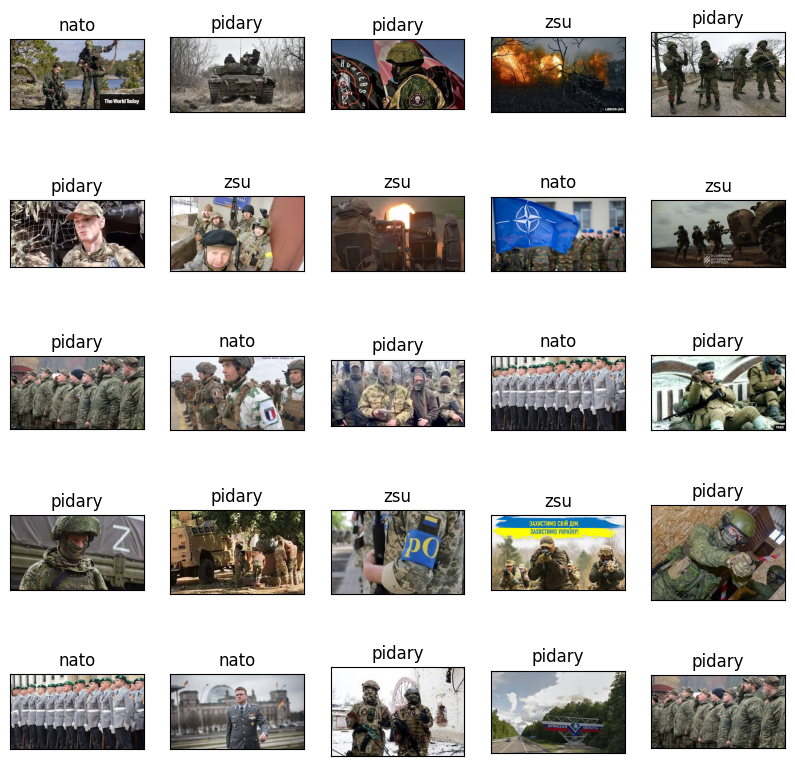

In [6]:
fig = plt.figure(figsize=(10, 10))
visualize_dataset = torchvision.datasets.ImageFolder(root=data_set_path + '/Train')
rows, columns = 5, 5
rand_indeces = np.random.randint(low=0, high=len(visualize_dataset), size=(rows*columns,))

images = []
labels = []

for i in rand_indeces:
    img, class_ = visualize_dataset[i]
    images.append(img)
    labels.append(visualize_dataset.classes[class_])

# visualize these random images
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(images[i-1])
    plt.xticks([])
    plt.yticks([])
    plt.title(f"{labels[i-1]}")


In [7]:
import torch.nn as nn

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=3):
        super(ResNet, self).__init__()
        self.in_channels = 128

        self.conv1 = nn.Conv2d(3, 128, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(128)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 128, layers[0])
        self.layer2 = self._make_layer(block, 256, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 512, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 1024, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(1024 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion)
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

def customresnet18(pretrained=False, **kwargs):
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    return model


In [8]:
from torchvision.models import ResNet18_Weights

# Number of classes in the dataset
num_classes = len(train_dataset.classes)

# Batch size for training (change depending on how much memory you have)
batch_size = 350

# Number of epochs to train for
num_epochs = 50

# Device for running training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
# model = models.resnet18(pretrained=True)
model = customresnet18()

# Training only the last layer, the other layers are freezed
#for param in model.parameters():
#    param.requires_grad = False

#num_ftrs = model.fc.in_features
#model.fc = nn.Linear(num_ftrs, num_classes)
#print(f"{num_ftrs = }")

## Helper Functions

In [9]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    train_acc_history = []
    train_loss_history = []

    val_acc_history = []
    val_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    y_pred_proba = torch.softmax(outputs, dim=1)
                    y_pred = y_pred_proba.argmax(dim=1)
                    # print(f"{y_pred = }")
                    # print(f"{labels = }")
                    # print(f"{y_pred.shape = }")
                    # print(f"{labels.shape = }")
                    # loss = criterion(y_pred_proba, labels)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                # print(f"{preds = }")
                # print(f"{labels.data = }")
                running_corrects += torch.sum(y_pred == labels)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, val_loss_history, train_acc_history, train_loss_history

## Load Data


In [10]:
# Create training and validation datasets

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Create training and validation dataloaders
dataloaders_dict = {
    "train": train_dataloader,
    "val": test_dataloader,
}



## Create the Optimizer


In [11]:
# Send the model to GPU
model = model.to(device)

# Observe that all parameters are being optimized
# optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
# optimizer_ft = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer_ft = optim.Adam(params=model.parameters())

## Run Training and Validation Step


In [12]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, val_acc_history, val_loss_history, train_acc_history, train_loss_history = train_model(model, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/49
----------
train Loss: 1.9204 Acc: 0.3483
val Loss: 3026.7076 Acc: 0.3242

Epoch 1/49
----------
train Loss: 1.1946 Acc: 0.3915
val Loss: 124.7089 Acc: 0.3242

Epoch 2/49
----------
train Loss: 1.1015 Acc: 0.4083
val Loss: 3.9970 Acc: 0.3529

Epoch 3/49
----------
train Loss: 1.0779 Acc: 0.4332
val Loss: 1.6158 Acc: 0.3817

Epoch 4/49
----------
train Loss: 1.0548 Acc: 0.4444
val Loss: 1.1994 Acc: 0.3417

Epoch 5/49
----------
train Loss: 1.0694 Acc: 0.4323
val Loss: 1.1226 Acc: 0.4343

Epoch 6/49
----------
train Loss: 1.0646 Acc: 0.4379
val Loss: 1.0792 Acc: 0.4205

Epoch 7/49
----------
train Loss: 1.0476 Acc: 0.4604
val Loss: 1.0788 Acc: 0.4543

Epoch 8/49
----------
train Loss: 1.0330 Acc: 0.4838
val Loss: 1.0588 Acc: 0.4618

Epoch 9/49
----------
train Loss: 1.0059 Acc: 0.5026
val Loss: 1.0660 Acc: 0.4506

Epoch 10/49
----------
train Loss: 1.0120 Acc: 0.5054
val Loss: 1.0742 Acc: 0.4518

Epoch 11/49
----------
train Loss: 0.9979 Acc: 0.4965
val Loss: 1.0052 Acc: 0.501

In [13]:
val_acc_history_cpu = [i.item() for i in val_acc_history]
val_loss_history_cpu = val_loss_history
train_acc_history_cpu = [i.item() for i in train_acc_history]
train_loss_history_cpu = train_loss_history

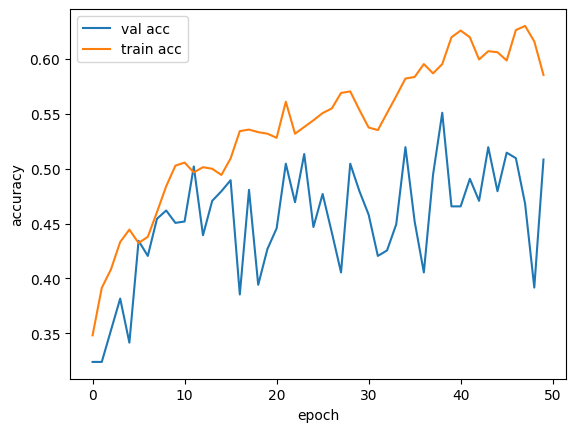

In [14]:
plt.plot(val_acc_history_cpu, label="val acc")
plt.plot(train_acc_history_cpu, label="train acc")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()

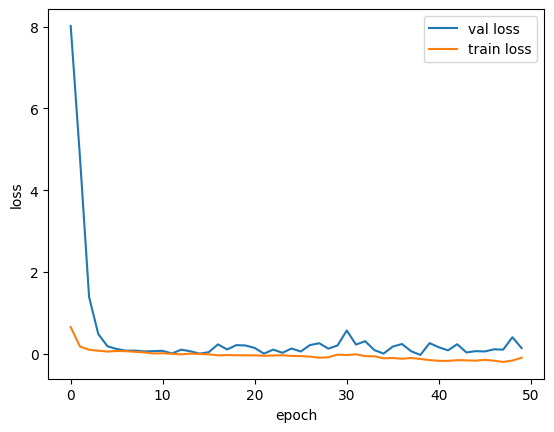

In [15]:
plt.plot(np.log(np.array(val_loss_history_cpu)), label="val loss")
plt.plot(np.log(np.array(train_loss_history_cpu)), label="train loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
torch.save(model.state_dict(), "mydataset_50.pth")